This notebook demonstrates how to use Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize which parts of an image a Convolutional Neural Network (CNN) is focusing on when making a classification decision.

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
import cv2

Data Loading and Preparation: The CIFAR-10 dataset is loaded and preprocessed for training.

In [ ]:
# Load and prepare data
print("Loading CIFAR-10 dataset...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

Loading CIFAR-10 dataset...


Model Creation and Training: A simple CNN model is built using the Keras Functional API and trained on a subset of the CIFAR-10 data.

In [ ]:
# Create and train model using Functional API
print("Creating simple CNN...")
inputs = tf.keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
conv_output = layers.Conv2D(64, (3, 3), activation='relu', name='target_conv')(x)
x = layers.Flatten()(conv_output)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train briefly
print("Training model...")
model.fit(x_train[:5000], y_train[:5000], epochs=30, validation_split=0.2, verbose=1)

# Generate predictions
sample_img = x_test[0:1]
predictions = model.predict(sample_img, verbose=0)
predicted_class = np.argmax(predictions[0])
true_class = y_test[0][0]

print(f"True class: {class_names[true_class]}")
print(f"Predicted class: {class_names[predicted_class]} (confidence: {predictions[0][predicted_class]:.3f})")

Creating simple CNN...
Training model...
Epoch 1/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.1660 - loss: 2.1916 - val_accuracy: 0.2880 - val_loss: 1.8548
Epoch 2/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3445 - loss: 1.7649 - val_accuracy: 0.3900 - val_loss: 1.6639
Epoch 3/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4118 - loss: 1.5978 - val_accuracy: 0.4720 - val_loss: 1.4958
Epoch 4/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4707 - loss: 1.4553 - val_accuracy: 0.4700 - val_loss: 1.4486
Epoch 5/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5196 - loss: 1.3205 - val_accuracy: 0.4780 - val_loss: 1.4310
Epoch 6/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5442 - loss: 1.2521 - val_accuracy: 0.4910 - val_loss: 1.4550
Epoch 7/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5647 - loss: 1.1909 - val_accuracy: 0.4950 - val_loss: 1.4300
Epoch 8/30
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy

Grad-CAM Implementation: A function generate_gradcam is defined to compute the Grad-CAM heatmap for a given image and predicted class.

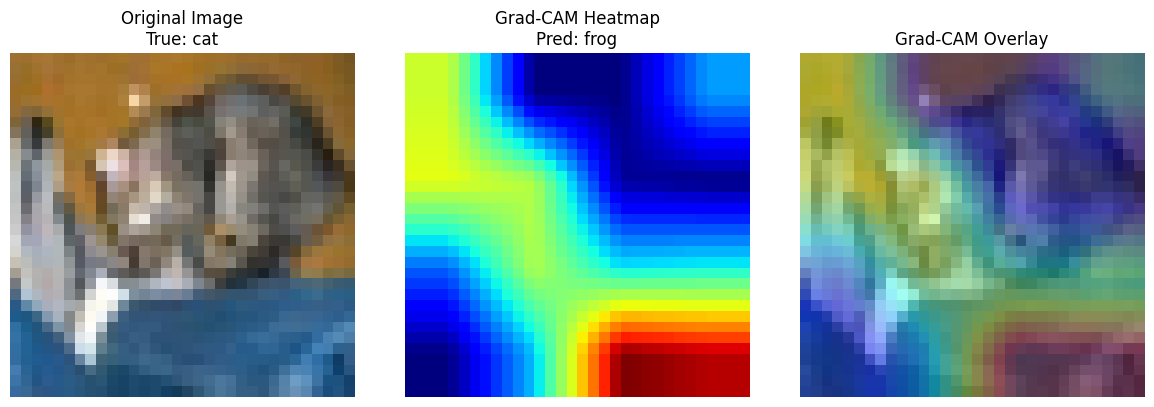

In [ ]:
# Grad-CAM implementation
def generate_gradcam(model, img_array, class_idx):
    # Get the target conv layer
    target_layer = model.get_layer('target_conv')

    # Create gradient model
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[target_layer.output, model.output]
    )

    # Calculate gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_idx]

    # Get gradients: ∂y^c/∂A^k_{i,j}
    grads = tape.gradient(loss, conv_outputs)

    # Calculate importance weights: α_k^c = (1/Z) Σ(∂y^c/∂A^k_{i,j})
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Generate heatmap: L_c^Grad-CAM = ReLU(Σ α_k^c A^k)
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Apply ReLU and normalize
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Generate Grad-CAM
heatmap = generate_gradcam(model, sample_img, predicted_class)

# Resize heatmap to image size
heatmap_resized = cv2.resize(heatmap, (32, 32))

Visualization: The original image, the generated heatmap, and an overlay of the heatmap on the image are displayed to show the areas of importance for the model's prediction.

In [ ]:
# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Original image
axes[0].imshow(sample_img[0])
axes[0].set_title(f'Original Image\nTrue: {class_names[true_class]}')
axes[0].axis('off')

# Heatmap
axes[1].imshow(heatmap_resized, cmap='jet')
axes[1].set_title(f'Grad-CAM Heatmap\nPred: {class_names[predicted_class]}')
axes[1].axis('off')

# Overlay
superimposed = 0.6 * sample_img[0] + 0.4 * plt.cm.jet(heatmap_resized)[:,:,:3]
axes[2].imshow(superimposed)
axes[2].set_title('Grad-CAM Overlay')
axes[2].axis('off')

plt.tight_layout()
plt.show()

Feature Importance Analysis: The importance weights of the feature maps in the target convolutional layer are visualized to understand which features contribute most to the prediction.

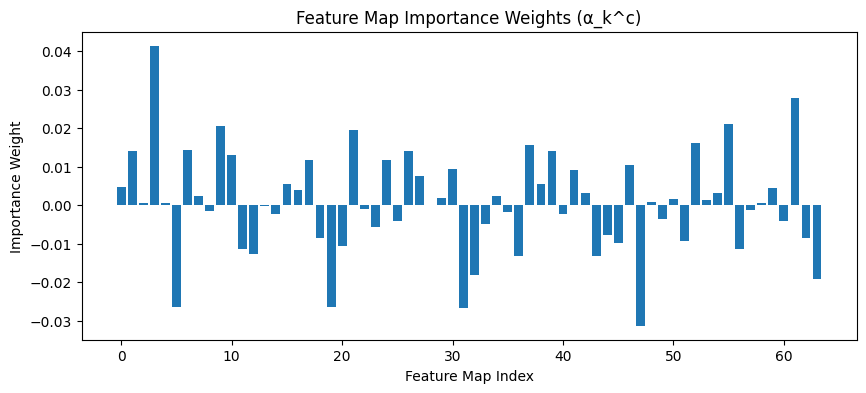


Grad-CAM Analysis Complete!
- Total feature maps: 64
- Most important feature: 3 (weight: 0.041)
- Least important feature: 47 (weight: -0.031)


In [ ]:
# Show feature importance
target_layer = model.get_layer('target_conv')
grad_model = tf.keras.models.Model(inputs=model.input, outputs=[target_layer.output, model.output])
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(sample_img)
    loss = predictions[:, predicted_class]
grads = tape.gradient(loss, conv_outputs)
weights = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()

plt.figure(figsize=(10, 4))
plt.bar(range(len(weights)), weights)
plt.title('Feature Map Importance Weights (α_k^c)')
plt.xlabel('Feature Map Index')
plt.ylabel('Importance Weight')
plt.show()

print(f"\nGrad-CAM Analysis Complete!")
print(f"- Total feature maps: {len(weights)}")
print(f"- Most important feature: {np.argmax(weights)} (weight: {np.max(weights):.3f})")
print(f"- Least important feature: {np.argmin(weights)} (weight: {np.min(weights):.3f})")